In [1]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seabeepy as sb

plt.style.use("ggplot")

# SeaBee annotation workflow

This notebook includes some useful functions to streamline the SeaBee annotation workflow. See the documentation [here](https://seabee-no.github.io/annotation/quarto/annotation_docs.html) for details.

## 1. User input

In [2]:
# Version of the Excel class definitions to use
class_version = "0-1"

# Folder containing annotation shapefiles
# Must NOT contain any other shapefiles!
shp_fold = r"../vector/annotation_by_subarea"

# Shapefile defining annotation subareas
# Must include a field/column in the attribute table with a unique ID for each subarea
subarea_shp_path = r"../vector/2022-08-31_Remoy_subareas_UTM32.shp"
subarea_id_field = "id"

# Shapefile defining region of interest
roi_shp_path = r"../vector/2022-08-31_Remoy_ROI.shp"

# Output annotation shapefile to create
anno_shp_path = r"../vector/2022-08-31_Remoy_Annotation_Merged_v0-1.shp"

# Output geopackage to create
gpkg_path = r"../vector/2022-08-31_Remoy_Annotation.gpkg"

## 2. Create class definition file

Create a class definition file compatible with ArcGIS Pro from an Excel table. The Excel file **must** be structured with four columns, as in the example below:

|    **A**    |      **B**      |      **C**      |                      **D**                     |
|:-----------:|:---------------:|:---------------:|:----------------------------------------------:|
| **Level_1** |   **Level_2**   |   **Level_3**   |                 **Level3_Desc**                |
|    ALGAE    |       RED       |      PALPA      |             Palmaria palmata (søl)             |
|    ALGAE    |       RED       |      VERLA      | Vertebrata lanosa (grisetangdokke/trøffeltang) |
|    ALGAE    |       TURF      |       TURF      |             Unspecified turf (lurv)            |
|    MAERL    |      MAERL      |      MAERL      |     Unspecified maerl (rugl, Lithothamnion)    |
|    URCHIN   |      URCHIN     |      ECHES      |       Echinus esculentus (rød kråkebolle)      |
|  BEACHCAST  | BEACHCAST_BROWN | BEACHCAST_BROWN |      Unspecified, dried seaweed (Tangvoll)     |
|  BEACHCAST  | BEACHCAST_ANGIO | BEACHCAST_ANGIO |    Unspecified, dried seagass (sjøgressvoll)   |
|    ANGIO    |      ANGIO      |      ZOSMA      |            Zostera marina (ålegras)            |

The output is an `.ecs` file (JSON) that can be loaded into the Training Samples Manager.

In [3]:
# Read Excel file
class_version = class_version.replace(".", "-")
xl_path = f"../class_definitions/seabee_habitat_classes_v{class_version}.xlsx"
df = pd.read_excel(xl_path, usecols="A:D")
df.head()

,1st level,2nd level,3rd level,Species/habitat
0,ALGAE,BROWN,ALAES,Alaria esculenta (butare)
1,ALGAE,BROWN,CHOFI,Chorda filum (martaum)
2,ALGAE,BROWN,DESVI,Desmarestia viridis (mykt kjerringhår)
3,ALGAE,BROWN,LAMHY,Laminaria hyperborea (stortare)
4,ALGAE,BROWN,LAMDI,Laminaria digitata (fingertare)


In [4]:
# Convert to .ecs
name = f"seabee_class_definitions_v{class_version}"
desc = f"v{class_version} of the SeaBee class definition file."

# Assign colours for levels 1 and 2; level 3 is assigned randomly
# For levels 1 and 2, if colours are not provided a random colour will be chosen
colour_dict = {
    0: {
        "ALGAE": "#0091ff",
        "MAERL": "#757472",
        "URCHIN": "#ff0000",
        "BEACHCAST": "#e67b09",
        "ANGIO": "#2da12b",
        "WOOD": "#a1952b",
        "GRASS": "#c1f507",
        "ROCK": "#b5b5b3",
        "SEDIMENT": "#ffff00",
        "ANTHRO": "#000000",
    },
    1: {
        "BROWN": "#6e5400",
        "GREEN": "#19b01b",
        "RED": "#912727",
        "TURF": "#9e219a",
        "MAERL": "#757472",
        "URCHIN": "#ff0000",
        "BEACHCAST_BROWN": "#e67b09",
        "BEACHCAST_ANGIO": "#03fcba",
        "ANGIO": "#2da12b",
        "WOOD": "#a1952b",
        "GRASS": "#c1f507",
        "BOULDER": "#b5b5b3",
        "COBBLE": "#b5b5b3",
        "GRAVEL": "#b5b5b3",
        "SAND": "#ffff00",
        "MUD": "#ffb700",
        "ANTHRO": "#000000",
    },
    2: {},
}

out_fold = r"../class_definitions"
sb.anno.class_definition_from_df(
    df,
    name,
    out_fold=out_fold,
    version=1,
    org="NIVA",
    desc=desc,
    colour_dict=colour_dict,
)

## 3. Merge shapefiles

During annotation, **all users should work with the same class definition file** (i.e. the `.ecs` created above). Annotations from all users for the same area can then be exported as shapefiles and added to a single folder. As long as the same class definition file has been used by everyone, the shapefiles will have a consistent structure with the same classes. These can therefore be merged and "dissolved" to create a single annotation dataset for the whole area.

In [5]:
# Merge and dissolve annotation shapefiles for each subarea
# Make sure 'shp_fold' ONLY conatins annotation shapefiles!
gdf = sb.anno.merge_shapefiles(shp_fold)
gdf.head()

,Classcode,geometry,Classname,Classvalue,RED,GREEN,BLUE,Count
0,1010,MULTIPOLYGON Z (((327495.808 6919026.787 0.000...,BROWN,1010,110,84,0,11380513
1,101011,MULTIPOLYGON Z (((327779.479 6918781.130 0.000...,CHOFI,101011,199,213,142,190595
2,101013,"POLYGON Z ((327579.802 6919134.632 0.000, 3275...",LAMHY,101013,193,112,148,269
3,101015,MULTIPOLYGON Z (((327921.269 6919074.332 0.000...,PELCA,101015,94,185,211,148
4,101016,MULTIPOLYGON Z (((327438.523 6919105.534 0.000...,SACLA,101016,99,138,156,699362


## 4. Assign subareas

The merged shapefile above is intersected with the subarea polygons to create a set of training samples split by subarea.

In [6]:
# Assign subarea IDs
subarea_gdf = gpd.read_file(subarea_shp_path)
subarea_gdf.rename({subarea_id_field: "subarea_id"}, axis="columns", inplace=True)
subarea_gdf = subarea_gdf[["subarea_id", "geometry"]]
gdf = gdf.overlay(subarea_gdf, how="intersection")
gdf.head()

,Classcode,Classname,Classvalue,RED,GREEN,BLUE,Count,subarea_id,geometry
0,1010,BROWN,1010,110,84,0,11380513,1,MULTIPOLYGON Z (((327651.742 6919106.760 0.000...
1,101013,LAMHY,101013,193,112,148,269,1,"POLYGON Z ((327579.792 6919134.622 0.000, 3275..."
2,101015,PELCA,101015,94,185,211,148,1,MULTIPOLYGON Z (((327614.196 6919172.274 0.000...
3,101016,SACLA,101016,99,138,156,699362,1,MULTIPOLYGON Z (((327633.285 6919114.145 0.000...
4,101018,ASCNO,101018,106,71,53,228769,1,MULTIPOLYGON Z (((327649.111 6919130.432 0.000...


## 5. Rebuild the class hierarchy

ArcGIS Pro stores all annotation in a single field (`Classname`), regardless of the level in the `.ecs` hierarchy. For machine learning, it is better to have one column of class labels per level, as this makes it easier to generate raster training datasets using labels for any level. To get around this limitation, `class_definition_from_df` embeds the hierarchy in the `Classcode`, so that it can be reconstructed afterwards. This is done by the function below.

In [7]:
# Extract annotation levels to separate columns
class_def_path = f"../class_definitions/{name}.ecs"
gdf = sb.anno.rebuild_class_hierarchy(gdf, class_def_path)
gdf.to_file(anno_shp_path, index=False)
gdf.head()

,subarea_id,lev1_code,lev2_code,lev3_code,lev1_name,lev2_name,lev3_name,lev3_desc,red,green,blue,geometry
0,1,10,1010,1010--,ALGAE,BROWN,None,None,110,84,0,MULTIPOLYGON Z (((327442.965 6919065.723 0.000...
1,1,10,1010,101013,ALGAE,BROWN,LAMHY,Laminaria hyperborea (stortare),193,112,148,"POLYGON Z ((327579.792 6919134.622 0.000, 3275..."
2,1,10,1010,101015,ALGAE,BROWN,PELCA,Pelevetia canaliculata (sauetang),94,185,211,MULTIPOLYGON Z (((327591.990 6919128.699 0.000...
3,1,10,1010,101016,ALGAE,BROWN,SACLA,Saccharina latissima (sukkertare),99,138,156,MULTIPOLYGON Z (((327438.550 6919105.524 0.000...
4,1,10,1010,101018,ALGAE,BROWN,ASCNO,Ascophyllum nodosum (grisetang),106,71,53,MULTIPOLYGON Z (((327422.964 6919154.719 0.000...


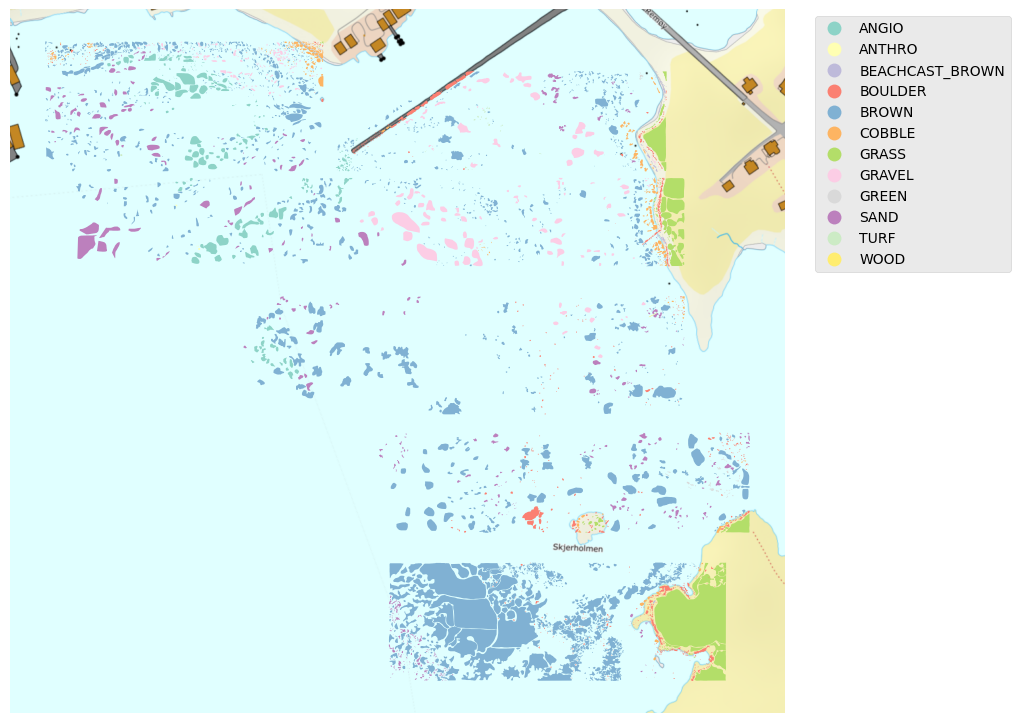

In [8]:
# Plot
ax = gdf.plot(
    column="lev2_name", cmap="Set3", categorical=True, legend=True, figsize=(10, 10)
)
cx.add_basemap(
    ax,
    crs=gdf.crs.to_string(),
    attribution=False,
    source="https://cache.kartverket.no/topo4/v1/gmaps/{z}/{x}/{y}.png",
    # source=cx.providers.OpenStreetMap.Mapnik,
)
leg = ax.get_legend()
leg.set_bbox_to_anchor((1, 0.0, 0.3, 1))
ax.axis("off");

## 6. Create geopackage

In [9]:
# Save annotation, ROI and subareas to a geopackage
shp_path_dict = {
    "annotation": anno_shp_path,
    "region_of_interest": roi_shp_path,
    "subareas": subarea_shp_path,
}
epsg = gdf.crs.to_epsg()
for layer, shp_path in shp_path_dict.items():
    gdf = gpd.read_file(shp_path)
    assert (
        gdf.crs.to_epsg() == epsg
    ), f"CRS for layer '{layer}' does not match annotation dataset."
    gdf.to_file(gpkg_path, layer=layer, driver="GPKG", index=False)